In [83]:
import pandas as pd
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# Data frame for the last three month (SEP,AUG,JUL)
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [210925, 210828, 210724]
df = get_data(week_nums)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628867 entries, 0 to 209398
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count   Dtype 
---  ------                                                                --------------   ----- 
 0   C/A                                                                   628867 non-null  object
 1   UNIT                                                                  628867 non-null  object
 2   SCP                                                                   628867 non-null  object
 3   STATION                                                               628867 non-null  object
 4   LINENAME                                                              628867 non-null  object
 5   DIVISION                                                              628867 non-null  object
 6   DATE                                                                  628867 non-null  objec

In [9]:
turnstiles_df.TIME.dtypes

dtype('O')

In [11]:
df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [12]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,00:00:00,REGULAR,7637026,2613455,2021-09-18 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,04:00:00,REGULAR,7637036,2613457,2021-09-18 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,08:00:00,REGULAR,7637047,2613478,2021-09-18 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,12:00:00,REGULAR,7637104,2613524,2021-09-18 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,16:00:00,REGULAR,7637236,2613561,2021-09-18 16:00:00


In [17]:
df.columns = [column.strip() for column in df.columns]

In [18]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)
# to check if we have dublicate value

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
565308,R514,R094,00-05-00,ASTORIA BLVD,2021-07-22 12:00:00,2
623867,S101,R070,00-00-02,ST. GEORGE,2021-09-18 00:00:00,2
564340,R514,R094,00-00-00,ASTORIA BLVD,2021-09-22 12:00:00,2
623873,S101,R070,00-00-02,ST. GEORGE,2021-09-19 00:00:00,2
623872,S101,R070,00-00-02,ST. GEORGE,2021-09-18 20:00:00,2


In [46]:
# Get rid of the duplicate entry
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [47]:
daily_df = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE","DATE_TIME"],as_index=False)
                        .ENTRIES.first())

In [48]:
daily_df[["PREV_DATE", "PREV_ENTRIES"]] = (daily_df.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

<ipython-input-48-3570f5d86822>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_df[["PREV_DATE", "PREV_ENTRIES"]] = (daily_df.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


In [49]:
daily_df.head()

,C/A,UNIT,SCP,STATION,DATE,DATE_TIME,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 00:00:00,7603734,NaN,NaN
1,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 04:00:00,7603744,07/17/2021,7603734.0
2,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 08:00:00,7603756,07/17/2021,7603744.0
3,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 12:00:00,7603804,07/17/2021,7603756.0
4,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 16:00:00,7603900,07/17/2021,7603804.0


In [50]:
daily_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [51]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
daily_df["DAILY_ENTRIES"] = daily_df.apply(get_daily_counts, axis=1, max_counter=1000000)

193 8049630.0
167790067 702272.0
151 5610355.0
35 9769328.0
33570198 181535.0
31 8714868.0
10596 3268116.0
0 117440512.0
344353 7577027.0
327682 67109640.0
461 1198122.0
46 5405537.0
2508 705353287.0
16777689 1037129.0
6 16034831.0
3695 6205980.0
292 1947911.0
7538 15680090.0
8 1255797.0
43 3154069.0
8368 3098922.0
1881 2570099.0
50362839 251769.0
33236 1953264.0
14255 4788322.0
105 6246092.0
1140 1040930263.0
113192 3523950.0
201338499 795030.0
641 5764026.0
1089962103 146735572.0
3542824 51735160.0
6742 2030205.0
3422 7676533.0
1189019447 3740789.0
2596 1683131.0
1387 6480842.0
3920 1383105332.0


In [92]:
ra = daily_df.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
ra.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,07/17/2021,2605.0
1,A002,R051,59 ST,07/18/2021,2783.0
2,A002,R051,59 ST,07/19/2021,4813.0
3,A002,R051,59 ST,07/20/2021,5243.0
4,A002,R051,59 ST,07/21/2021,5425.0


In [82]:
Zero_Entries= pd.DataFrame(daily_df[daily_df['DAILY_ENTRIES'] == 0])
Zero_Entries['DATE_TIME'].shape

(102643,)

In [96]:
each_station = daily_df.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

In [101]:
station_totals = each_station.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()
station_totals.head()

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,3382513.0
1,FULTON ST,3364946.0
2,86 ST,2508638.0
3,PATH NEW WTC,2449198.0
4,72 ST,2407906.0


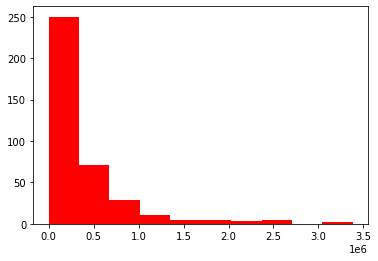

In [110]:
plt.hist(station_totals['DAILY_ENTRIES'], color="r");

In [107]:
x = daily_df.groupby('DATE_TIME')
x.head()
# x[x['DAILY_ENTRIES'] == 0]

,C/A,UNIT,SCP,STATION,DATE,DATE_TIME,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 04:00:00,7603744,07/17/2021,7603734.0,10.0
2,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 08:00:00,7603756,07/17/2021,7603744.0,12.0
3,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 12:00:00,7603804,07/17/2021,7603756.0,48.0
4,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 16:00:00,7603900,07/17/2021,7603804.0,96.0
5,A002,R051,02-00-00,59 ST,07/17/2021,2021-07-17 20:00:00,7604034,07/17/2021,7603900.0,134.0
...,...,...,...,...,...,...,...,...,...,...
628082,TRAM2,R469,00-00-00,RIT-ROOSEVELT,07/19/2021,2021-07-19 09:12:54,881095,07/19/2021,881077.0,18.0
628209,TRAM2,R469,00-00-01,RIT-ROOSEVELT,07/19/2021,2021-07-19 09:12:54,3793638,07/19/2021,3793616.0,22.0
628336,TRAM2,R469,00-03-00,RIT-ROOSEVELT,07/19/2021,2021-07-19 09:12:54,755345,07/19/2021,755345.0,0.0
628463,TRAM2,R469,00-03-01,RIT-ROOSEVELT,07/19/2021,2021-07-19 09:12:54,3136190,07/19/2021,3136188.0,2.0


In [113]:
daily_df['DATE_TIME'];

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

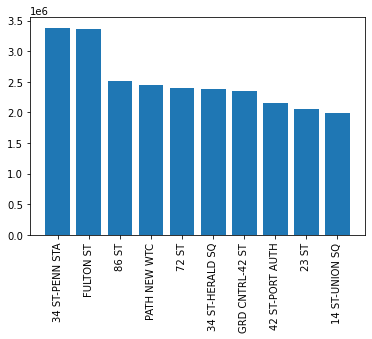

In [111]:
plt.bar(x=station_totals['STATION'][:10], height=station_totals['DAILY_ENTRIES'][:10]);
plt.xticks(rotation=90)

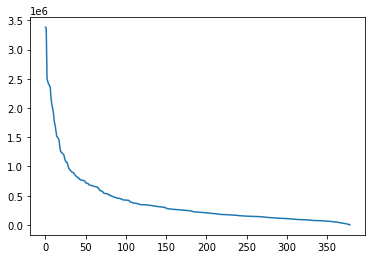

In [112]:
plt.plot(station_totals['DAILY_ENTRIES'])